<a href="https://colab.research.google.com/github/Wilsid-gtg/Big-Data/blob/main/spark%20SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install pyspark

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("SimpleDataFrame").getOrCreate()

data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, columns)
df.createOrReplaceTempView('employees')
spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()


+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
+-----+---+------+------+------+

+----+---+
|Name|Age|
+----+---+
|Anna| 28|
+----+---+

+------------------+
|       avg(Salary)|
+------------------+
|3266.6666666666665|
+------------------+



In [ ]:
spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()
# Cari rata-rata gaji per departemen.
spark.sql('''
SELECT DeptId, AVG(Salary) as TotalSalary
FROM employees
GROUP BY DeptId
ORDER BY TotalSalary
''').show()
# Temukan karyawan yang memiliki gaji di atas rata-rata untuk gender masing-masing.
spark.sql('''
SELECT Gender, Name FROM employees
where Salary > (select AVG(Salary) as TotalSalary from employees)
GROUP BY Gender, Name
ORDER BY Gender
''').show()
# Buat ranking karyawan berdasarkan gaji dalam departemen mereka.
spark.sql('''
SELECT Name, SUM(Salary) as TotalSalary, DeptId
FROM employees
GROUP BY DeptId, Name
ORDER BY DeptId
''').show()

+------+-----------+---+
|Gender|TotalSalary|Age|
+------+-----------+---+
|     M|       2700| 23|
|     F|       4100| 28|
|     M|       3000| 34|
+------+-----------+---+

+------+-----------+
|DeptId|TotalSalary|
+------+-----------+
|     1|     2850.0|
|     2|     4100.0|
+------+-----------+

+------+----+
|Gender|Name|
+------+----+
|     F|Anna|
+------+----+

+-----+-----------+------+
| Name|TotalSalary|DeptId|
+-----+-----------+------+
|James|       3000|     1|
|  Lee|       2700|     1|
| Anna|       4100|     2|
+-----+-----------+------+



In [ ]:
spark.sql('''
SELECT Name, Age, Salary, ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank
FROM employees
''').show()

+-----+---+------+----+
| Name|Age|Salary|rank|
+-----+---+------+----+
|  Lee| 23|  2700|   1|
| Anna| 28|  4100|   1|
|James| 34|  3000|   1|
+-----+---+------+----+



In [9]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Data setup for complex SQL queries
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Complex SQL query involving multiple joins and subqueries
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()
# query SQL untuk menemukan rata-rata gaji per departemen dan rangking setiap karyawan dalam departemen berdasarkan gaji
spark.sql('''
SELECT e.Name, e.Salary, d.DeptName,
AVG(e.Salary) OVER (PARTITION BY d.DeptName) as avg_salary,
Rank() OVER (PARTITION BY d.DeptName ORDER BY e.Salary DESC) as rank
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
''').show()
# window functions untuk menentukan tren gaji berdasarkan usia di setiap departemen.
spark.sql('''
SELECT e.Name, e.Age, e.Salary, d.DeptName,
SUM(e.Salary) OVER (PARTITION BY e.Age) as sum_salary,
Rank() OVER (PARTITION BY e.Age ORDER BY e.Salary DESC) as tren
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
''').show()

+-----+---+---------+-----------+
| Name|Age| DeptName|ProjectName|
+-----+---+---------+-----------+
|  Lee| 23|       HR|  Project A|
|James| 34|       HR|  Project A|
| Anna| 28|Marketing|  Project B|
+-----+---+---------+-----------+

+-----+------+---------+----------+----+
| Name|Salary| DeptName|avg_salary|rank|
+-----+------+---------+----------+----+
|James|  3000|       HR|    2850.0|   1|
|  Lee|  2700|       HR|    2850.0|   2|
| Anna|  4100|Marketing|    4100.0|   1|
+-----+------+---------+----------+----+

+-----+---+------+---------+----------+----+
| Name|Age|Salary| DeptName|sum_salary|tren|
+-----+---+------+---------+----------+----+
|  Lee| 23|  2700|       HR|      2700|   1|
| Anna| 28|  4100|Marketing|      4100|   1|
|James| 34|  3000|       HR|      3000|   1|
+-----+---+------+---------+----------+----+



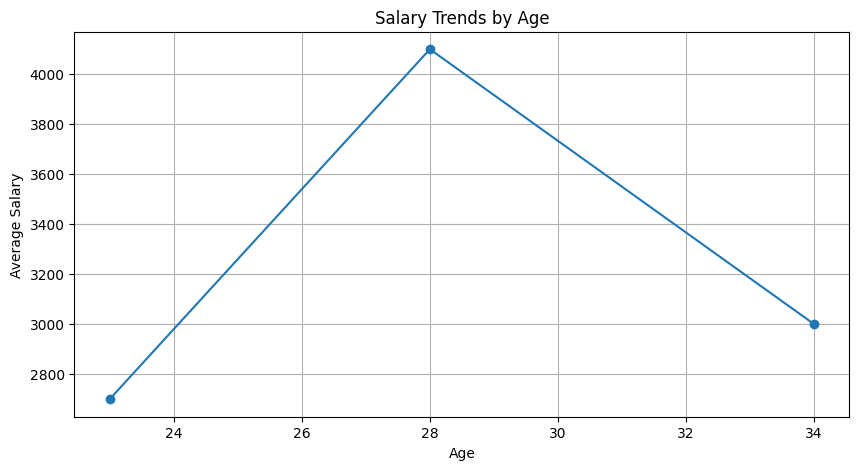

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization of salary trends
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()

In [10]:
spark.sql('''
SELECT  e.DeptId, d.DeptName,
COUNT(e.Name) as total_dept,
SUM(e.Salary) as total_Salary
from employees e
join departments d on e.DeptId = d.DeptId
group by d.DeptName, e.DeptId
order by DeptName
''').show()



+------+---------+----------+------------+
|DeptId| DeptName|total_dept|total_Salary|
+------+---------+----------+------------+
|     1|       HR|         2|        5700|
|     2|Marketing|         1|        4100|
+------+---------+----------+------------+



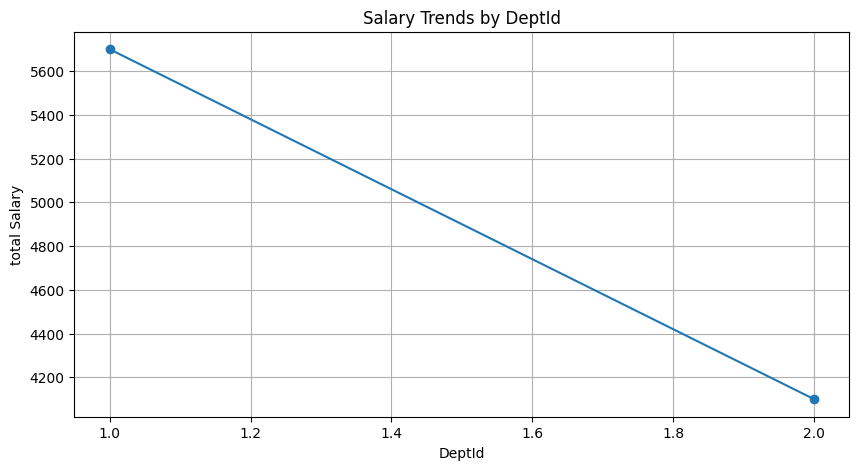

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT DeptId, sum(Salary) AS sumSalary
FROM employees
GROUP BY DeptId
ORDER BY DeptId
''').toPandas()

# Visualization of salary trends
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['DeptId'], salary_trends['sumSalary'], marker='o')
plt.xlabel('DeptId')
plt.ylabel('total Salary')
plt.title('Salary Trends by DeptId')
plt.grid(True)
plt.show()

In [ ]:
spark.sql('''
SELECT Age, Name FROM employees
where Salary > (select AVG(Salary) as TotalSalary from employees)
GROUP BY Age, Name
ORDER BY Age
''').show()

+---+----+
|Age|Name|
+---+----+
| 28|Anna|
+---+----+



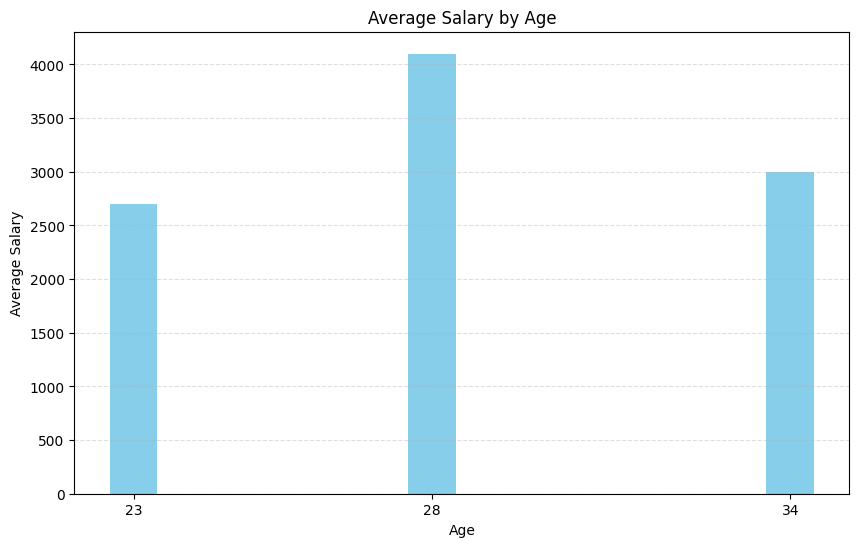

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization of salary trends
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(salary_trends['Age'], salary_trends['AverageSalary'], color='skyblue')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Average Salary by Age')
plt.grid(axis='y', linestyle='--', alpha=0.4)  # Optional: Add a grid for better readability
plt.xticks(salary_trends['Age']) # Ensure all age values are displayed on the x-axis

plt.show()

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Data setup for complex SQL queries
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1),
    ('John', 23, 'M', 2200, 3),
    ('Sam', 20, 'M', 2800, 4),
    ('Sins', 25, 'M', 2800, 1),
    ('Lia', 22, 'F', 2100, 3),
    ('Moa', 21, 'F', 2600, 1),
    ('Joko', 35, 'M', 4200, 2),
    ('Bowo', 33, 'M', 4000, 2),
    ('Vina', 22, 'M', 2900, 4),
    ('Kong', 28, 'M', 3000, 4),
    ('jia', 25, 'F', 2800, 4),
    ('Elly', 28, 'F', 2500, 3),
    ('Gany', 25, 'M', 2200, 3),
    ('Emi', 20, 'F', 2800, 4),
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing'),
    (3, 'OB'),
    (4, 'Employee')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B'),
    (3, 'No Project'),
    (4, 'Project D')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()
#rank gaji menurut departmen
spark.sql('''
SELECT e.Name, e.Salary, d.DeptName,
AVG(e.Salary) OVER (PARTITION BY d.DeptName) as avg_salary,
Rank() OVER (PARTITION BY d.DeptName ORDER BY e.Salary DESC) as rank
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
''').show()
# total gaji dan jumlah orang setiap departmen
spark.sql('''
SELECT  e.DeptId, d.DeptName,
COUNT(e.Name) as total_dept,
SUM(e.Salary) as total_Salary
from employees e
join departments d on e.DeptId = d.DeptId
group by d.DeptName, e.DeptId
order by DeptName
''').show()

+-----+---+---------+-----------+
| Name|Age| DeptName|ProjectName|
+-----+---+---------+-----------+
|  Moa| 21|       HR|  Project A|
| Sins| 25|       HR|  Project A|
|  Lee| 23|       HR|  Project A|
|James| 34|       HR|  Project A|
| Bowo| 33|Marketing|  Project B|
| Joko| 35|Marketing|  Project B|
| Anna| 28|Marketing|  Project B|
| Gany| 25|       OB| No Project|
| Elly| 28|       OB| No Project|
|  Lia| 22|       OB| No Project|
| John| 23|       OB| No Project|
|  Emi| 20| Employee|  Project D|
|  jia| 25| Employee|  Project D|
| Kong| 28| Employee|  Project D|
| Vina| 22| Employee|  Project D|
|  Sam| 20| Employee|  Project D|
+-----+---+---------+-----------+

+-----+------+---------+----------+----+
| Name|Salary| DeptName|avg_salary|rank|
+-----+------+---------+----------+----+
| Kong|  3000| Employee|    2860.0|   1|
| Vina|  2900| Employee|    2860.0|   2|
|  Sam|  2800| Employee|    2860.0|   3|
|  jia|  2800| Employee|    2860.0|   3|
|  Emi|  2800| Employee|    2860

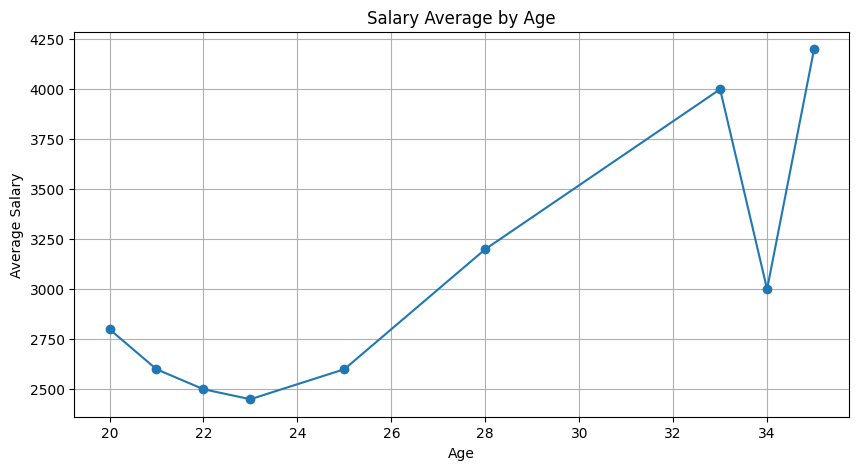

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization of salary trends
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Average by Age')
plt.grid(True)
plt.show()